# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

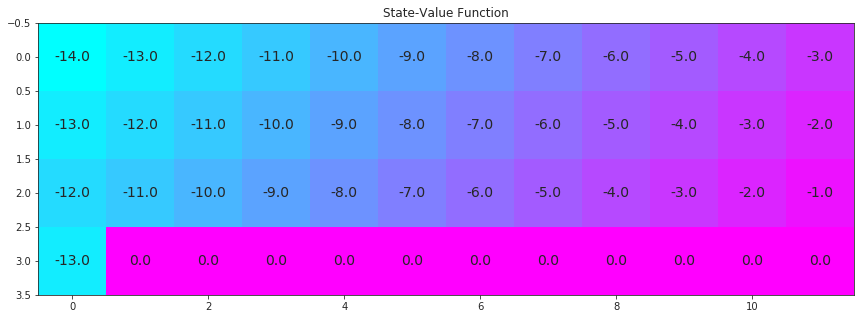

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0] = -np.arange(3, 15)[::-1]
V_opt[1] = -np.arange(3, 15)[::-1] + 1
V_opt[2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

In [5]:
pol_opt = np.hstack((np.ones(11), 2, 0))

print(pol_opt)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 0.]


### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def eps_greedy_policy(Q, epsilon, state, nA):
    if state in Q:
        best_action = np.argmax(Q[state])
        if np.random.uniform()>epsilon:
            return best_action
    return np.random.choice(np.arange(nA))

In [7]:
def sarsa_update(Q, transition, alpha, gamma):
    state, action, reward, done, next_state, next_action = transition
    q_t = Q[state][action]
    q_tp1 = Q[next_state][next_action]
    td_target = reward + (gamma * (1-done) * q_tp1)
    Q[state][action] = q_t + alpha * (td_target-q_t)
    return Q[state][action]

In [8]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize performance monitor
    ep_scores = deque(maxlen=100)
    avg_ep_scores = deque(maxlen = num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):   
        ## TODO: complete the function    
        eps = 1.0/i_episode
        score = 0
        state = env.reset()
        action = eps_greedy_policy(Q, eps, state, nA)
        while True:
            
            next_state, reward, done, info = env.step(action)
            score += reward
            next_action = eps_greedy_policy(Q, eps, next_state, nA)
            transition = state, action, reward, done, next_state, next_action
            
            Q[state][action] = sarsa_update(Q, transition, alpha, gamma)
            if done:
                ep_scores.append(score)
                break
            state = next_state
            action = next_action
            
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            avg_ep_scores.append(np.mean(ep_scores))
            
            
    plt.plot(np.linspace(0,num_episodes,len(avg_ep_scores),endpoint=False), np.asarray(avg_ep_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(avg_ep_scores))
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

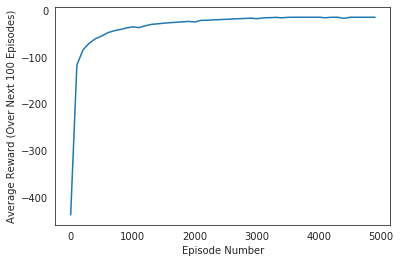

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  3  1  1  0  1  1  0  2  1  2]
 [ 0  1  1  0  1  2  1  1  0  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


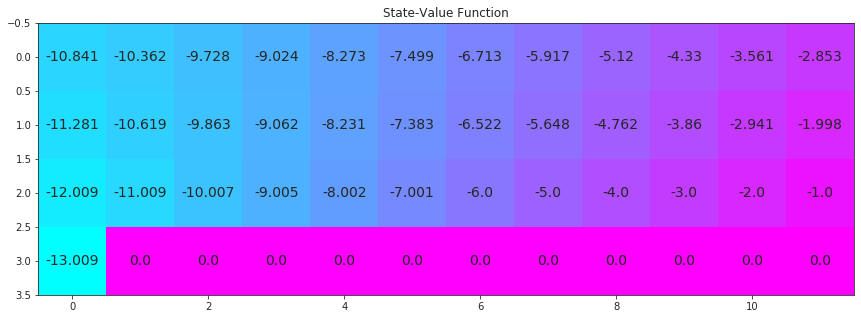

In [9]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [10]:
def qlearning_update(Q, transition, alpha, gamma):
    state, action, reward, done, next_state = transition
    q_t = Q[state][action]
    q_tp1 = np.max(Q[next_state])
    td_target = reward + (gamma * (1-done) * q_tp1)
    Q[state][action] = q_t + alpha * (td_target-q_t)
    return Q[state][action]

In [11]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    ep_scores = deque(maxlen=100)
    avg_ep_scores = deque(maxlen = num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):  
        
        ## TODO: complete the function    
        eps = 1.0/i_episode
        score = 0
        state = env.reset()
       
        while True:
            action = eps_greedy_policy(Q, eps, state, nA)
            next_state, reward, done, info = env.step(action)
            score += reward
            transition = state, action, reward, done, next_state
            Q[state][action] = qlearning_update(Q, transition, alpha, gamma)
            if done:
                ep_scores.append(score)
                break
            state = next_state
            
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            avg_ep_scores.append(np.mean(ep_scores))
            
            
    plt.plot(np.linspace(0,num_episodes,len(avg_ep_scores),endpoint=False), np.asarray(avg_ep_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(avg_ep_scores))
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

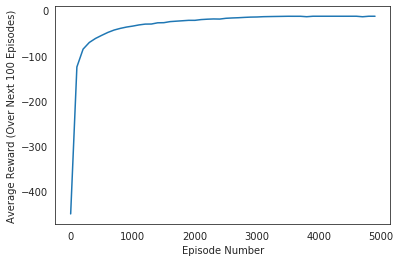

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  3  0  1  1  1  1  1  2]
 [ 0  0  0  0  1  1  2  0  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


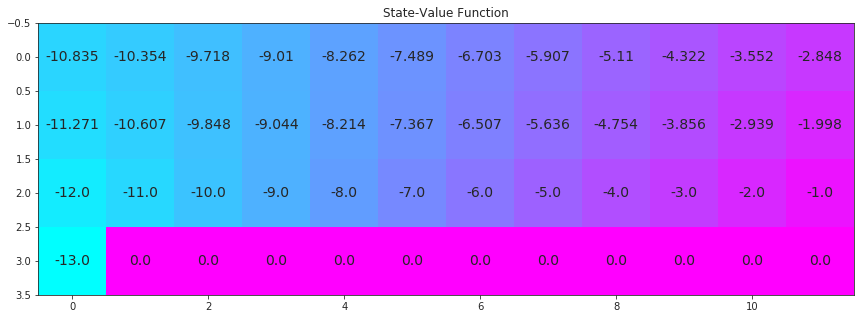

In [12]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [13]:
def exp_sarsa_update(Q, transition, eps, alpha, gamma):
    state, action, reward, done, next_state = transition
    nA = Q[state].shape[0]
    q_t = Q[state][action]
    best_q = np.max(Q[next_state])
    exp_q = ((1-eps)*best_q) + ((eps/nA)*sum(Q[next_state]))
    td_target = reward + (gamma * (1-done) * exp_q)
    Q[state][action] = q_t + alpha * (td_target-q_t)
    return Q[state][action]

In [16]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    ep_scores = deque(maxlen=100)
    avg_ep_scores = deque(maxlen = num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):  
        
        ## TODO: complete the function    
        eps = 0.005
        score = 0
        state = env.reset()
       
        while True:
            action = eps_greedy_policy(Q, eps, state, nA)
            next_state, reward, done, info = env.step(action)
            score += reward
            transition = state, action, reward, done, next_state
            Q[state][action] = exp_sarsa_update(Q, transition, eps, alpha, gamma)
            if done:
                ep_scores.append(score)
                break
            state = next_state
            
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            avg_ep_scores.append(np.mean(ep_scores))
            
            
    plt.plot(np.linspace(0,num_episodes,len(avg_ep_scores),endpoint=False), np.asarray(avg_ep_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(avg_ep_scores))
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

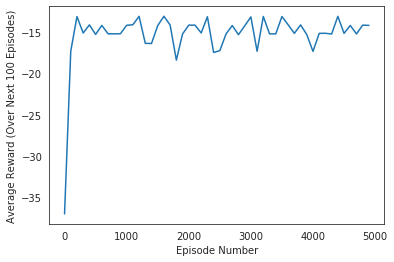

Best Average Reward over 100 Episodes:  -13.04


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  1  3  1  1  0  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


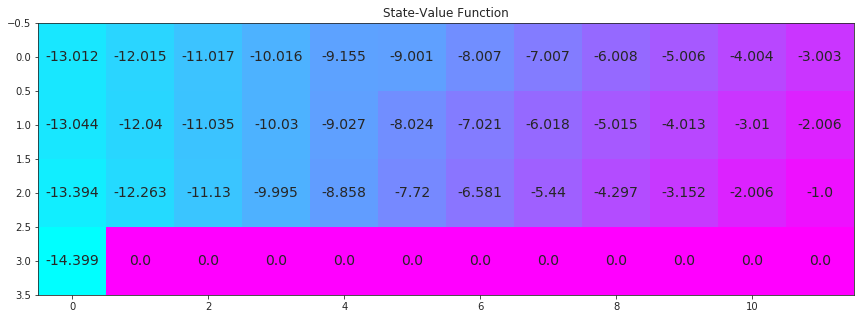

In [17]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])